In [750]:
# Check platform.
import platform
if platform.machine() not in ['x86_64', 'aarch64']:
    raise SystemExit("Unsupported platform!")

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to clickhouse on remote server
import clickhouse_connect

# Import the channel estimator and some utilities for converting
# the DMRS fields in the right format from the SCF FAPI format that the dataset follows.
from aerial.phy5g.algorithms import ChannelEstimator
from aerial.util.fapi import dmrs_fapi_to_bit_array

clickhouse_client = clickhouse_connect.get_client(host='localhost')

In [940]:
import datetime
import heapq

def average_of_largest(arr, n=20):
    if len(arr) < n:
        return sum(arr) / len(arr)  # If there are less than 10 elements, take the average of all
    largest_numbers = heapq.nlargest(n, arr)  # Get the n largest numbers
    return sum(largest_numbers) / n  # Compute the average

In [752]:
import pandas as pd
import matplotlib.pyplot as plt

In [763]:
query = """SELECT test_id, MAX(timestamp) as latest_timestamp
FROM iperf3db
GROUP BY test_id
ORDER BY latest_timestamp;"""
tests =  clickhouse_client.query(query)
result_rows = tests.result_rows
print(result_rows)
test_ids = [row[0] for row in result_rows]
print(test_ids)
len(test_ids)

[('ce78584823cb4117b8ca7dab20329d18', datetime.datetime(2025, 3, 31, 9, 41, 56)), ('b95d4fc9d9264955be19c714ebcf67aa', datetime.datetime(2025, 3, 31, 9, 47, 38)), ('8718729281eb43659c585c1030cc5b7c', datetime.datetime(2025, 3, 31, 9, 56, 25)), ('0495f79e08074d02a797eba68fafbdaf', datetime.datetime(2025, 3, 31, 10, 0, 15)), ('76b992cfc91246798f5c2da365a5598b', datetime.datetime(2025, 3, 31, 10, 8, 21)), ('5e53fc9755e14efd9cee9cdacb005234', datetime.datetime(2025, 3, 31, 10, 12, 44)), ('7a814bccd33e4378a1b6ca2ce43cfe89', datetime.datetime(2025, 3, 31, 12, 1, 23)), ('9d185c365c664004aaa5ab862ecc64b2', datetime.datetime(2025, 3, 31, 12, 13, 8)), ('c6f3f359e6384291aae4de56f0a1d525', datetime.datetime(2025, 3, 31, 12, 20, 38)), ('27ff9cdb12ab424a8a2cc7a49efad51c', datetime.datetime(2025, 3, 31, 12, 53, 7)), ('31b6a66c2c844361905df953a529e8f5', datetime.datetime(2025, 3, 31, 12, 58, 16)), ('b17c87a4c19e4616a5cb0d56bb4156ba', datetime.datetime(2025, 4, 1, 3, 26, 45)), ('ecf33c1ce4ed46a38534caa

15

In [1031]:
dataset = []
for test_id in test_ids:
    print(f"--- Test ID: {test_id}")
    # query = f"SELECT * FROM iperf3db WHERE test_id = '{test[0]}' ORDER BY 'timestamp' DESC"
    query = """
    SELECT *
    FROM iperf3db
    WHERE test_id = '%s' AND direction = 0
    ORDER BY timestamp
    """ % (test_id)
    # print(query)
    results =  clickhouse_client.query_df(query)
    # print(results)
    # print(len(results))

    start_timestamp = results['timestamp'][0] 
    stop_timestamp = results['timestamp'].iloc[-1]
    print(start_timestamp)
    print(stop_timestamp)
    ul_throughputs = results["throughput_mbps"].to_numpy()
    # print(dl_throughputs)
    # print(ul_throughputs)
    max_ul_throughput = average_of_largest(ul_throughputs)
    print(max_ul_throughput)

    # query = f"""
    # SELECT * FROM fapi 
    # WHERE TsTaiNs BETWEEN '{start_timestamp}' AND '{stop_timestamp}'
    # ORDER BY TsTaiNs DESC
    # """
    # print(query)
    # fapi = clickhouse_client.query_df(query)

    # # Plotting rbSize over time
    # plt.figure(figsize=(10, 6))
    # plt.plot(fapi['TsTaiNs'], fapi['rbSize'], marker='o', linestyle='-', color='b')

    # # Adding labels and title
    # plt.title('rbSize vs Time')
    # plt.xlabel('Time')
    # plt.ylabel('rbSize')
    # plt.grid(True)
    
    # # Display the plot
    # plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    # plt.tight_layout()  # Adjust the plot to fit labels
    # plt.show()

    df_thrput = results
    start_stop_times = []
    for i in range(0, len(df_thrput)):
        if i == 0:
            start_time = df_thrput['timestamp'][i]
            continue
        if i == len(df_thrput) - 1:
            stop_time = df_thrput['timestamp'][i]
            start_stop_times.append((start_time, stop_time))
        if df_thrput['target_throughput_mbps'][i] != df_thrput['target_throughput_mbps'][i-1]:
            # Capture the stop time for the previous value (when it changes)
            stop_time = df_thrput['timestamp'][i-1]
            # print((start_time, stop_time))
            start_stop_times.append((start_time, stop_time))
            start_time = df_thrput['timestamp'][i]

    # start_stop_times = start_stop_times[0:1]
    for start_stop_time in start_stop_times:
        query = f"""
        SELECT * FROM MAC_KPIs 
        WHERE TsTaiNs BETWEEN '{start_stop_time[0]}' AND '{start_stop_time[1]}'
        ORDER BY TsTaiNs DESC
        """
        # print(query)
        kpis = clickhouse_client.query_df(query)
        # print(results)
        dataset.append({
            "y" : max_ul_throughput,
            "xs" : kpis[['phr', 'wb_cqi']].to_numpy() / np.array([100, 20]),
        })

--- Test ID: ce78584823cb4117b8ca7dab20329d18
2025-03-31 09:40:20
2025-03-31 09:41:56
48.7059022701166
--- Test ID: b95d4fc9d9264955be19c714ebcf67aa
2025-03-31 09:46:03
2025-03-31 09:47:38
44.8340153452366
--- Test ID: 8718729281eb43659c585c1030cc5b7c
2025-03-31 09:54:51
2025-03-31 09:56:25
58.567028473243184
--- Test ID: 0495f79e08074d02a797eba68fafbdaf
2025-03-31 09:58:39
2025-03-31 10:00:15
48.45950105660413
--- Test ID: 76b992cfc91246798f5c2da365a5598b
2025-03-31 10:06:46
2025-03-31 10:08:21
52.123947971977735
--- Test ID: 5e53fc9755e14efd9cee9cdacb005234
2025-03-31 10:11:01
2025-03-31 10:12:44
25.374506754115828
--- Test ID: 7a814bccd33e4378a1b6ca2ce43cfe89
2025-03-31 11:59:49
2025-03-31 12:01:23
62.98302513517526
--- Test ID: 9d185c365c664004aaa5ab862ecc64b2
2025-03-31 12:11:34
2025-03-31 12:13:08
61.429015194590036
--- Test ID: c6f3f359e6384291aae4de56f0a1d525
2025-03-31 12:19:03
2025-03-31 12:20:38
38.64322664019372
--- Test ID: 27ff9cdb12ab424a8a2cc7a49efad51c
2025-03-31 12:51

In [1034]:
dataset = []
for test_id in test_ids:
    print(f"--- Test ID: {test_id}")
    # query = f"SELECT * FROM iperf3db WHERE test_id = '{test[0]}' ORDER BY 'timestamp' DESC"
    query = """
    SELECT *
    FROM iperf3db
    WHERE test_id = '%s' AND direction = 0
    ORDER BY timestamp
    """ % (test_id)
    # print(query)
    results =  clickhouse_client.query_df(query)
    # print(results)
    # print(len(results))

    start_timestamp = results['timestamp'][0] 
    stop_timestamp = results['timestamp'].iloc[-1]
    print(start_timestamp)
    print(stop_timestamp)
    ul_throughputs = results["throughput_mbps"].to_numpy()
    # print(dl_throughputs)
    # print(ul_throughputs)
    max_ul_throughput = average_of_largest(ul_throughputs)
    print(max_ul_throughput)

    query = f"""
    SELECT * FROM MAC_KPIs 
    WHERE TsTaiNs BETWEEN '{start_timestamp}' AND '{stop_timestamp}'
    ORDER BY TsTaiNs DESC
    """
    # print(query)
    kpis = clickhouse_client.query_df(query)
    # print(results)
    dataset.append({
        "y" : max_ul_throughput,
        "xs" : kpis[['phr', 'wb_cqi', 'pusch_snr', 'rsrp']].to_numpy() / np.array([100, 20, 30, -150]),
    })

--- Test ID: ce78584823cb4117b8ca7dab20329d18
2025-03-31 09:40:20
2025-03-31 09:41:56
48.7059022701166
--- Test ID: b95d4fc9d9264955be19c714ebcf67aa
2025-03-31 09:46:03
2025-03-31 09:47:38
44.8340153452366
--- Test ID: 8718729281eb43659c585c1030cc5b7c
2025-03-31 09:54:51
2025-03-31 09:56:25
58.567028473243184
--- Test ID: 0495f79e08074d02a797eba68fafbdaf
2025-03-31 09:58:39
2025-03-31 10:00:15
48.45950105660413
--- Test ID: 76b992cfc91246798f5c2da365a5598b
2025-03-31 10:06:46
2025-03-31 10:08:21
52.123947971977735
--- Test ID: 5e53fc9755e14efd9cee9cdacb005234
2025-03-31 10:11:01
2025-03-31 10:12:44
25.374506754115828
--- Test ID: 7a814bccd33e4378a1b6ca2ce43cfe89
2025-03-31 11:59:49
2025-03-31 12:01:23
62.98302513517526
--- Test ID: 9d185c365c664004aaa5ab862ecc64b2
2025-03-31 12:11:34
2025-03-31 12:13:08
61.429015194590036
--- Test ID: c6f3f359e6384291aae4de56f0a1d525
2025-03-31 12:19:03
2025-03-31 12:20:38
38.64322664019372
--- Test ID: 27ff9cdb12ab424a8a2cc7a49efad51c
2025-03-31 12:51

In [1035]:
print(len(dataset))
# dataset = [dataset[0], dataset[1], dataset[5]]
# dataset = dataset[:5]
print(len(dataset))
print(dataset[0]['xs'].shape)
print(len(dataset[0]['xs']))

15
15
(1719, 4)
1719


[48.7059022701166, 44.8340153452366, 58.567028473243184, 48.45950105660413, 52.123947971977735, 25.374506754115828, 62.98302513517526, 61.429015194590036, 38.64322664019372, 50.673804930762046, 17.371474544449338, 66.05778053764729, 61.482417177944924, 69.64778951256552, 29.38354968987622]


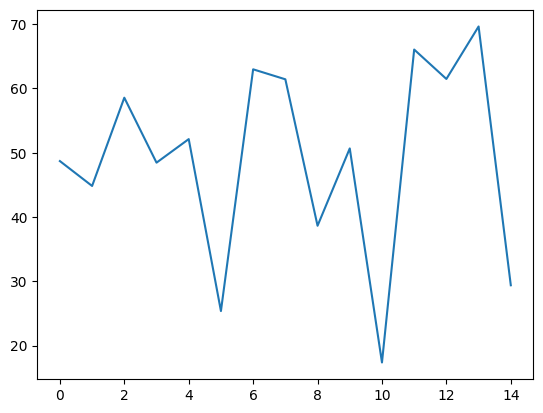

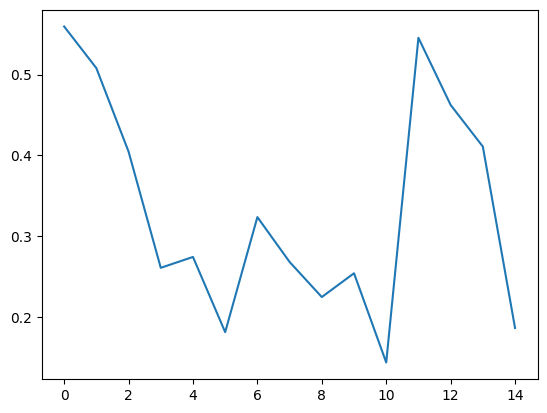

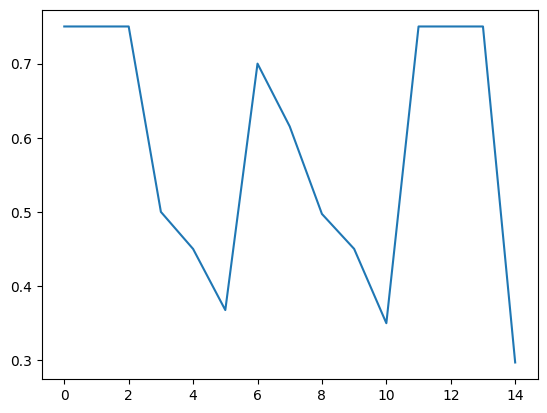

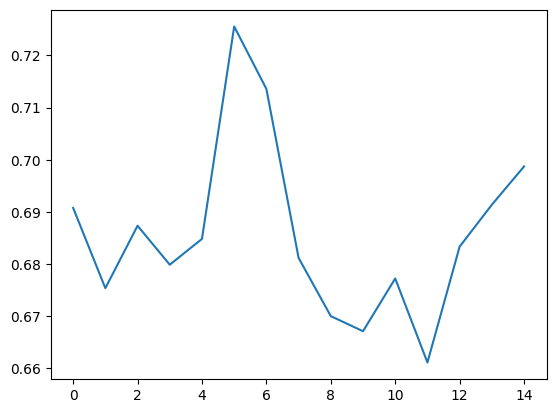

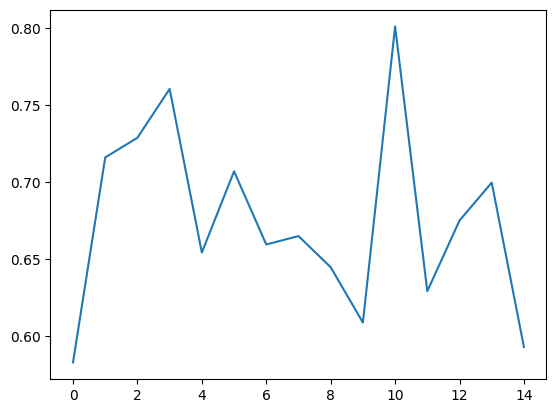

In [1036]:
from matplotlib import pyplot as plt
y = [data['y'] for data in dataset]
print(y)
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,0]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,1]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,2]) for data in dataset]
plt.plot(y)
plt.show()
y = [np.average(data['xs'][:,3]) for data in dataset]
plt.plot(y)
plt.show()

In [1003]:
!pip3 install torch
!pip3 install torchinfo
# !pip install torch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# !pip install torchinfo
from torchinfo import summary

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1004]:
print(torch.cuda.device_count())  # Number of GPUs available
device = torch.device("cuda:0")  # Select the first GPU (index 0)
print(device)

1
cuda:0


In [1005]:
X_SIZE = 4
HIDDEN_SIZE = 50
NUMBER_OF_LAYER = 2
DROP_OUT = 0.1

FC_LAYER_1_SIZE = 50
FC_LAYER_2_SIZE = 25
FC_OUTPUT_SIZE = 1

WINDOWS_SIZE = 20

In [1037]:
X_list = []
y_list = []
for data in dataset:
    y = data['y']
    n_samples = len(data['xs']) - WINDOWS_SIZE + 1
    # print(n_samples)
    for j in range(n_samples):
        X_list.append(data['xs'][j:j+WINDOWS_SIZE])
        y_list.append(y)

In [1038]:
print(len(X_list))
print(len(y_list))

35620
35620


In [1039]:
X_torch = torch.tensor(X_list, dtype=torch.float32)
X_torch.shape

torch.Size([35620, 20, 4])

In [1040]:
y_torch = torch.tensor(y_list, dtype=torch.float32)
y_torch.shape

torch.Size([35620])

In [911]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    """LSTM unit for regression"""

    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=X_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUMBER_OF_LAYER,
            batch_first=True,
            dropout=DROP_OUT if NUMBER_OF_LAYER > 1 else 0.0,  # Ensure dropout applies correctly
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(HIDDEN_SIZE, FC_LAYER_1_SIZE),  # Match LSTM hidden size
        #     nn.Linear(FC_LAYER_1_SIZE, FC_LAYER_2_SIZE),
        #     nn.Linear(FC_LAYER_2_SIZE, FC_OUTPUT_SIZE),
        # )

        self.fc = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, FC_LAYER_1_SIZE),
            nn.ReLU(),
            nn.Linear(FC_LAYER_1_SIZE, FC_OUTPUT_SIZE)
        )

    def forward(self, x):
        """out: [batch_size, seq_len, hidden_size]"""
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]  # Ensure correct indexing
        out = self.fc(last_out)
        return out  # Remove unnecessary squeeze


In [912]:
class GRUBased(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUBased, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0):
        # x: (batch_size, sequence_length, input_size)
        # h0: (num_layers, batch_size, hidden_size)
        
        out, hn = self.gru(x, h0)  # GRU forward pass
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out, hn

In [913]:
import dill
model = LSTM()
# model = GRUBased(X_SIZE, HIDDEN_SIZE, NUMBER_OF_LAYER)
model_stats = summary(model)
print(model_stats)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              31,600
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       2,550
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       51
Total params: 34,201
Trainable params: 34,201
Non-trainable params: 0


In [914]:
model.to(device)
model.train(True)

LSTM(
  (lstm): LSTM(4, 50, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [1055]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.0000005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00000001, weight_decay=0.00000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000000001, weight_decay=0.00000005)

In [1057]:
from torch.utils.data import DataLoader, TensorDataset

# Wrap in TensorDataset
tdataset = TensorDataset(X_torch, y_torch)

# Create DataLoader
train_data = DataLoader(tdataset, batch_size=2**12, shuffle=False, drop_last=True)

In [1058]:
# Training loop
num_epochs = 100000

model.train()
optimizer.zero_grad()

# h0 = torch.zeros(num_layers, batch_size, hidden_size)

# Forward pass
# outputs = model(trainX)
# print(outputs.shape)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    total_loss = 0
    for i, train_data_ in enumerate(train_data, 0):
        inputs, targets = train_data_
        trainX_ = inputs.to(device)
        trainY_ = targets.to(device)
        # print(trainX_.shape)
        
        # Forward pass
        outputs = model(trainX_)
    
        # Compute loss
        loss = criterion(outputs, trainY_)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_data)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4096])) that is different to the input size (torch.Size([4096, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100000], Loss: 286.7170
Epoch [20/100000], Loss: 286.5871
Epoch [30/100000], Loss: 286.7802
Epoch [40/100000], Loss: 286.7442
Epoch [50/100000], Loss: 286.7386
Epoch [60/100000], Loss: 286.6559
Epoch [70/100000], Loss: 286.6946
Epoch [80/100000], Loss: 286.8404
Epoch [90/100000], Loss: 286.7194
Epoch [100/100000], Loss: 286.9165
Epoch [110/100000], Loss: 286.9449
Epoch [120/100000], Loss: 286.8386
Epoch [130/100000], Loss: 286.7249
Epoch [140/100000], Loss: 286.7117
Epoch [150/100000], Loss: 286.7131
Epoch [160/100000], Loss: 286.8067
Epoch [170/100000], Loss: 286.6701
Epoch [180/100000], Loss: 286.6787
Epoch [190/100000], Loss: 286.7403
Epoch [200/100000], Loss: 286.7563
Epoch [210/100000], Loss: 287.0131
Epoch [220/100000], Loss: 286.7065
Epoch [230/100000], Loss: 286.7650
Epoch [240/100000], Loss: 286.7258
Epoch [250/100000], Loss: 286.7440
Epoch [260/100000], Loss: 286.4781
Epoch [270/100000], Loss: 286.5613
Epoch [280/100000], Loss: 286.7674
Epoch [290/100000], Loss: 286

KeyboardInterrupt: 

torch.Size([35620, 1])
torch.Size([35620, 20, 4])
(35620,)


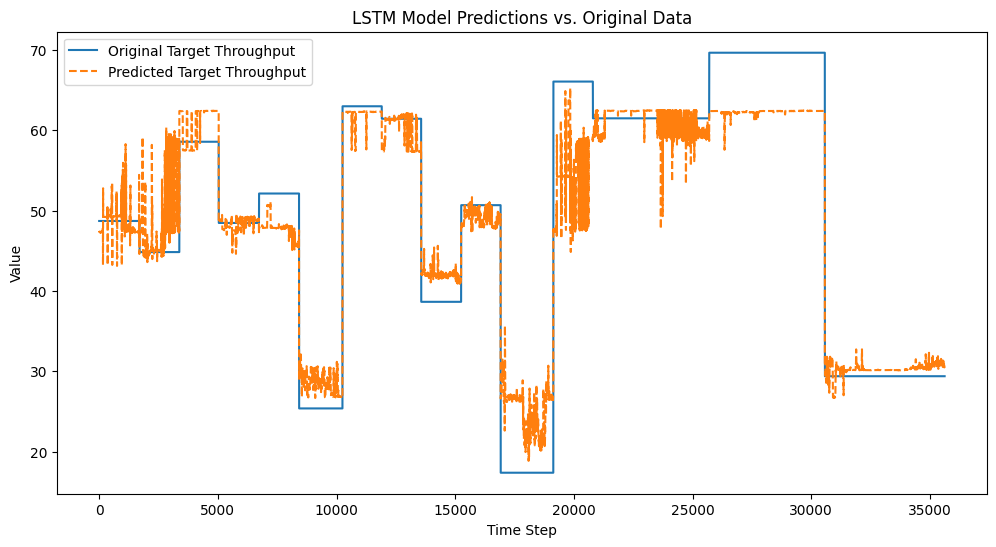

In [1061]:
# Predicted outputs
model.eval()

predicted = model(X_torch.to(device)).to("cpu")
print(predicted.shape)
print(X_torch.shape)
# print(X_torch[0])
# print(X_torch[9940])

# # Adjusting the original data and prediction for plotting
original = y_torch[:]  # Original data from the end of the first sequence
time_steps = np.arange(0, len(y_torch))  # Corresponding time steps
print(time_steps.shape)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Target Throughput')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Target Throughput', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [1062]:
torch.save(model, "model_2025_04_02_19_14.pth", pickle_module=dill)